# Generative modelling in deep learning due to 1 month(Next practical session)

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by an other algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some ways to compare two given distributions $p_D$ and $p_\theta$?**

We can compare two distributions by comparing their : mean, median, variance, divergence, covariance, statistical
We can use a Chi-squared test too.
The goal here is to find a distance between the two datasets

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them directly.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

Values sampled are not the true distribution and can be biased.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strenghts and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimentional gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

> Without noise we would have a deterministic function so it would be impossible to train the algorithm because we would have every time the same distribution at the end. The dimension of the input noise N has to be large enough becuase if N is too small it would be too fast to optimize the algorithm and it would not be enough trained. True distributions are not perfect and add noise is a way to simulate their imperfections and make a strong algorithm.

By construction, this generator structure only allows sampling of the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$. Such a model seems to need a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to differentiate examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator (whose output is denoted by $D(x)$) is trained using a classic discrimination loss, so that $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the JSD between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> The loss expression contains an integer 2log(2) It is a loss which will quickly saturate to 2log(2) because when we have two identical distribution it send us 2log(2) and it will be hard to train the classifier because it will send few informations to the algorithm.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what can this imply?**

> All the feedback of the generator is that our samplings are similar or not but the generator doesn't see the real data directly. It can be a problem because if our data contain a lot of different things the generator cound not see that it misses somme data. If he doesn't generate a type of data it won't have bad feedback on it.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be 25 Gaussian distributions with small variance, distributed on a $5\times 5$ grid.

In [39]:
import torch
import math

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the 25-gaussian dataset.
    
    return a torch tensor of dimensions (batchlen, 2)
    """
    # to sample from the gaussian mixture, we first sample the means for each point, then
    # add a gaussian noise with small variance
    samples = torch.multinomial(torch.tensor([0.2,0.2,0.2,0.2,0.2]), 2*batchlen, replacement=True)
    means = (2.0 * (samples - 2.0)).view(batchlen,2).type(torch.FloatTensor)
    return torch.normal(means, 0.05)

Let's plot a batch, to see what the dataset looks like.

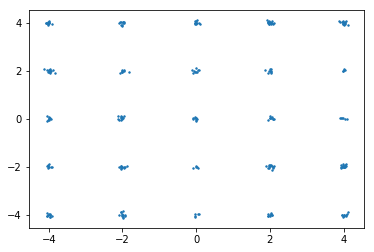

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(256)

plt.scatter(batch[:,0], batch[:,1], s=2.0, label='Batch of data from our gaussian mixture dataset')
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

When representing a binary classifier with a neural network, it is better for the last layer to consist of only a sigmoid activation, so that the output values will be between 0 and 1 and stand for the probability (according to the classifier) that the input is of the first class. The output is thus of the form $\mathrm{sigmoid}(h)$. The loss involves quantities such as $-\log(\mathrm{sigmoid}(h))$. For numerical stability reasons, it is recommended to rewrite the loss in order to make use of the $\mathrm{softplus}$ function defined by $\mathrm{softplus}(h) = \log(1 + \exp(h))$ and provided in PyTorch as `torch.softplus`.
As the $\mathrm{softplus}(h)$ formulation of the loss already contains the sigmoid activation, in practice the last layer of the discrimator network will not have any activation function (being just $h$).

In [65]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 1

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, 2)
        
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, 1)
    
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h)

With these classes in shape, only the training loop is still missing. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, its gradient will vanish (as seen in **Q4**) and thus no information will be passed to the generator.

We will then train the discriminator a fixed number of times between each training iteration of the generator.

In [42]:
def KL(batch1,batch2):
    z = torch.sum(batch1 * torch.log(batch1/batch2))
    return(z)

In [43]:
def JSD(batch1,batch2):
    M = 0.5 * (batch1+batch2)
    z = 0.5*(KL(batch1,M) + KL(batch2,M))
    return(z)

step 0: discriminator: -1.194e+02, generator: 2.063e+02


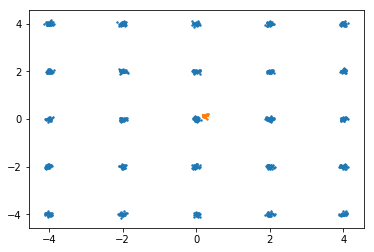

step 100: discriminator: -1.096e+02, generator: 1.375e+02


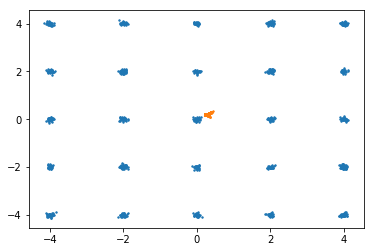

step 200: discriminator: -1.137e+02, generator: 1.826e+02


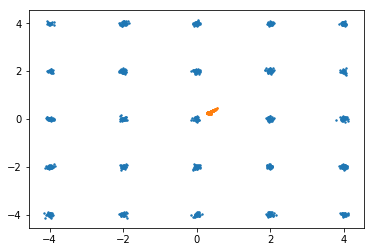

step 300: discriminator: -1.193e+02, generator: 1.738e+02


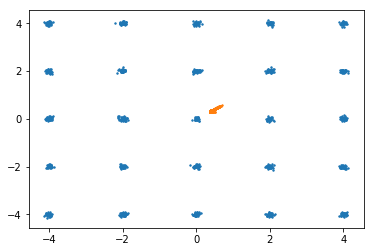

step 400: discriminator: -1.128e+02, generator: 1.639e+02


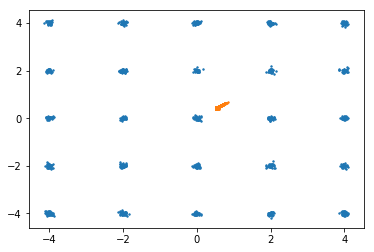

step 500: discriminator: -1.152e+02, generator: 1.111e+02


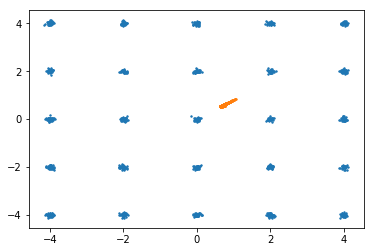

step 600: discriminator: -1.139e+02, generator: 1.078e+02


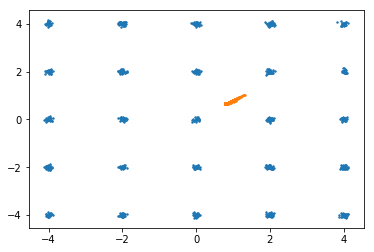

step 700: discriminator: -1.065e+02, generator: 3.800e+01


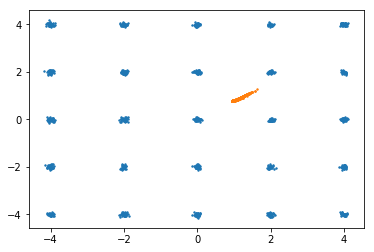

step 800: discriminator: -1.091e+02, generator: 5.906e+01


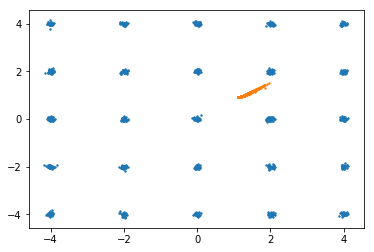

step 900: discriminator: -1.271e+02, generator: 1.418e-06


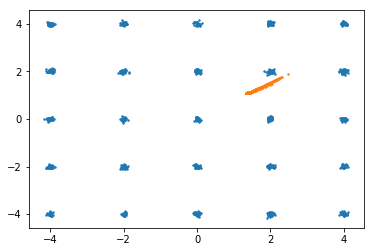

step 1000: discriminator: -1.277e+02, generator: 1.907e+01


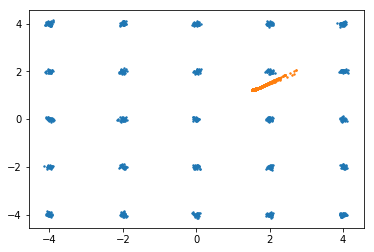

step 1100: discriminator: -1.359e+02, generator: 1.025e-08


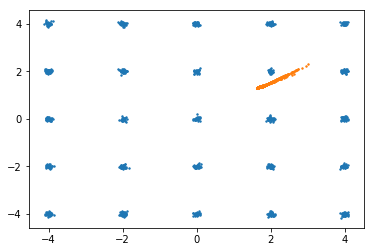

step 1200: discriminator: -1.487e+02, generator: 2.760e-28


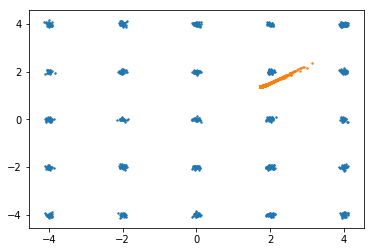

step 1300: discriminator: -1.402e+02, generator: 1.650e-03


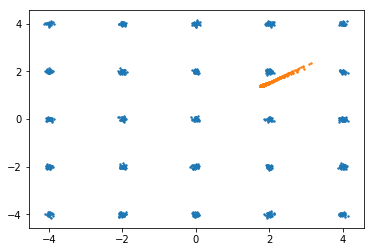

step 1400: discriminator: -1.478e+02, generator: 5.170e-06


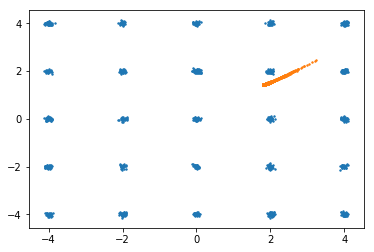

step 1500: discriminator: -1.476e+02, generator: 1.689e-17


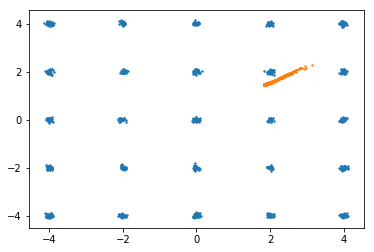

step 1600: discriminator: -1.450e+02, generator: 5.923e-14


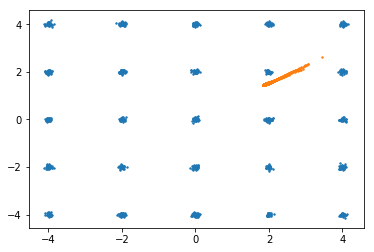

step 1700: discriminator: -1.467e+02, generator: 1.113e-16


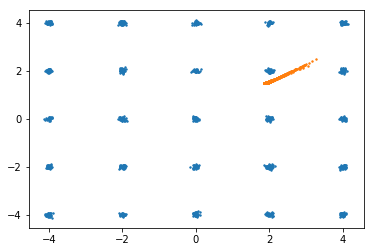

step 1800: discriminator: -1.608e+02, generator: 2.568e-36


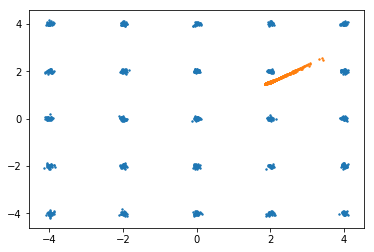

step 1900: discriminator: -1.435e+02, generator: 1.937e-20


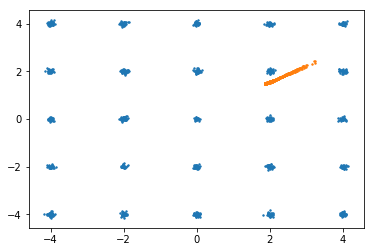

step 2000: discriminator: -1.518e+02, generator: 1.633e-33


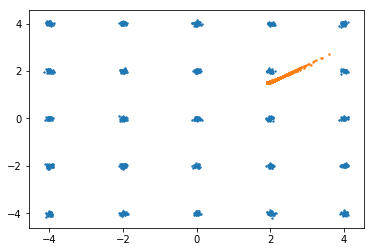

step 2100: discriminator: -1.461e+02, generator: 6.232e-19


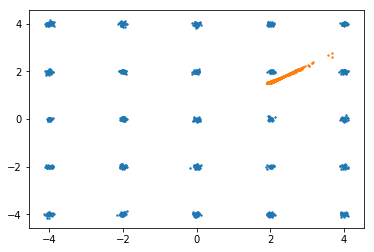

step 2200: discriminator: -1.623e+02, generator: 4.484e-44


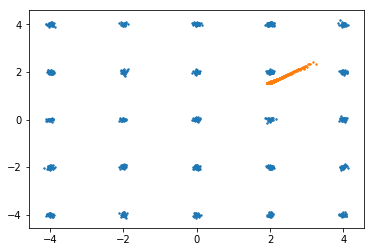

step 2300: discriminator: -1.528e+02, generator: 7.501e-39


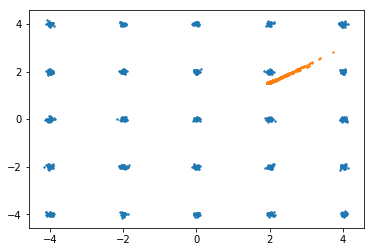

step 2400: discriminator: -1.569e+02, generator: 2.995e-26


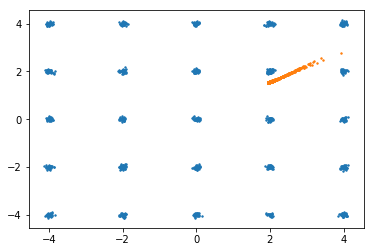

step 2500: discriminator: -1.643e+02, generator: 1.207e-42


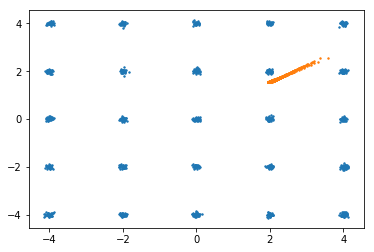

step 2600: discriminator: -1.537e+02, generator: 6.080e-29


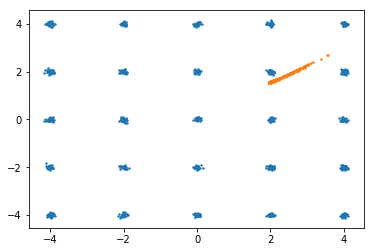

step 2700: discriminator: -1.576e+02, generator: 3.461e-43


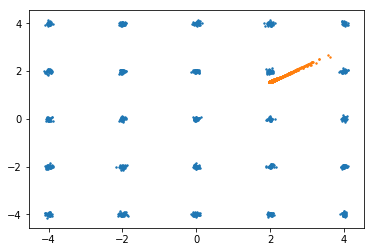

step 2800: discriminator: -1.565e+02, generator: 3.042e-25


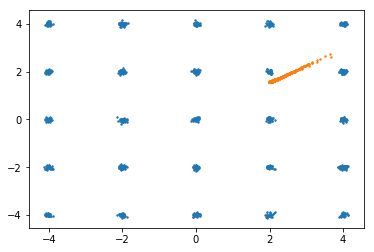

step 2900: discriminator: -1.590e+02, generator: 1.713e-36


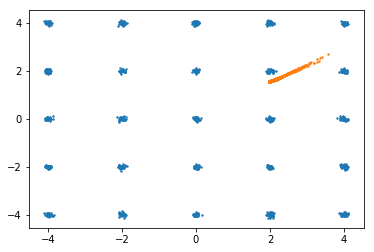

step 3000: discriminator: -1.554e+02, generator: 1.362e-24


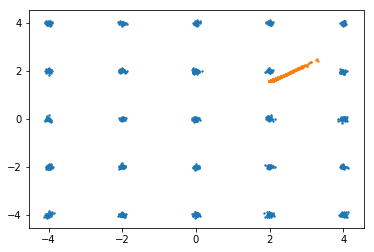

step 3100: discriminator: -1.717e+02, generator: 2.803e-45


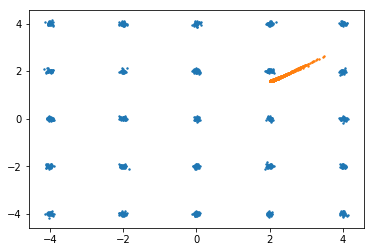

step 3200: discriminator: -1.682e+02, generator: 1.897e-34


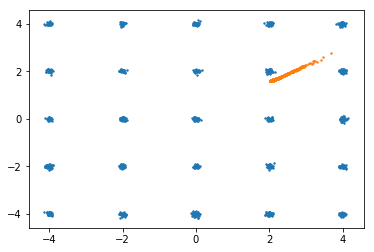

step 3300: discriminator: -1.637e+02, generator: 1.352e-34


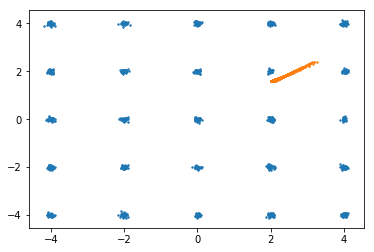

step 3400: discriminator: -1.545e+02, generator: 3.403e-29


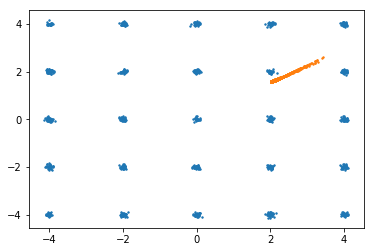

step 3500: discriminator: -1.513e+02, generator: 1.235e-11


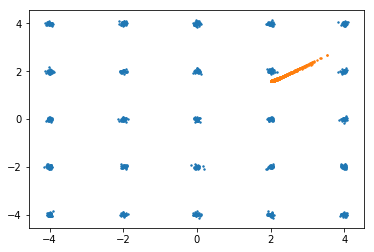

step 3600: discriminator: -1.498e+02, generator: 5.417e-13


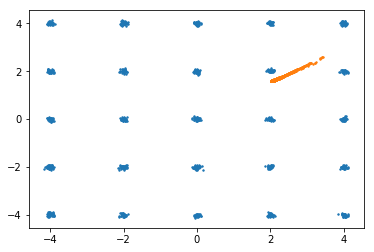

step 3700: discriminator: -1.618e+02, generator: 5.578e-34


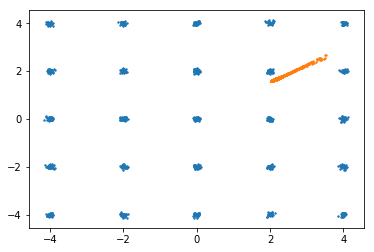

step 3800: discriminator: -1.510e+02, generator: 4.368e-22


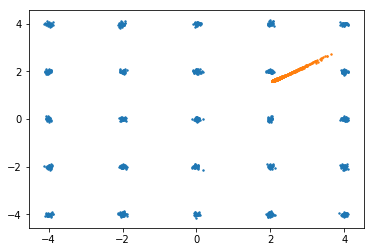

step 3900: discriminator: -1.546e+02, generator: 5.893e-29


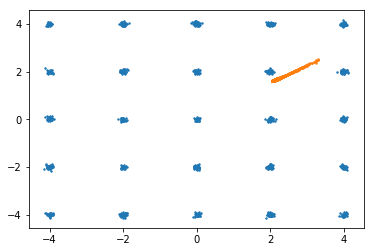

step 4000: discriminator: -1.595e+02, generator: 7.899e-26


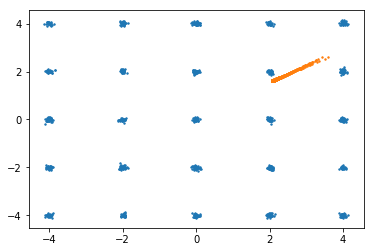

step 4100: discriminator: -1.656e+02, generator: 3.803e-35


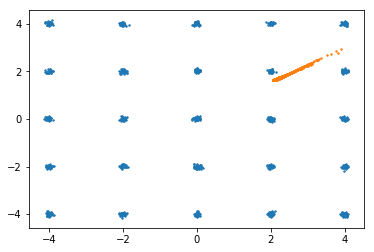

step 4200: discriminator: -1.487e+02, generator: 4.238e-35


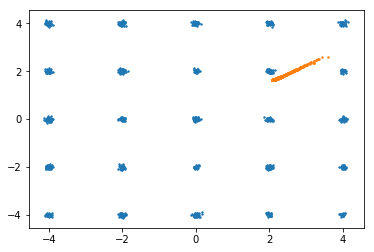

step 4300: discriminator: -1.624e+02, generator: 2.670e-36


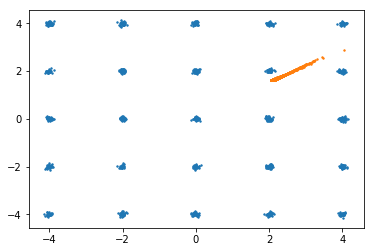

step 4400: discriminator: -1.739e+02, generator: 4.204e-45


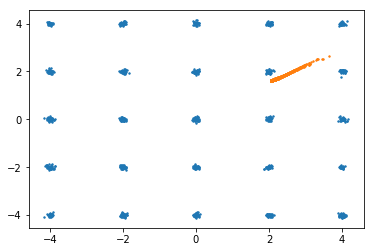

step 4500: discriminator: -1.711e+02, generator: 5.605e-45


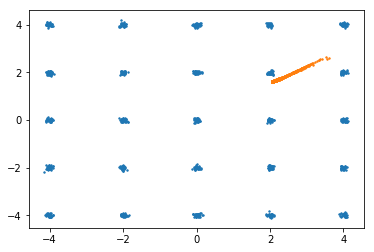

step 4600: discriminator: -1.651e+02, generator: 2.043e-41


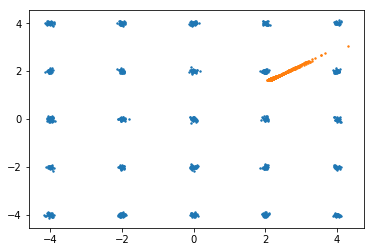

step 4700: discriminator: -1.581e+02, generator: 5.472e-21


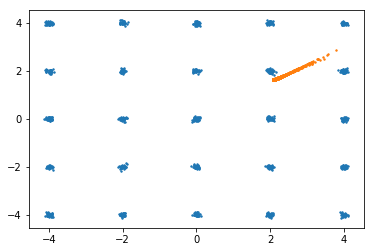

step 4800: discriminator: -1.536e+02, generator: 8.227e-17


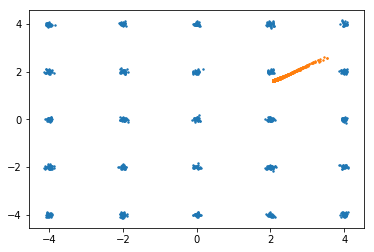

step 4900: discriminator: -1.613e+02, generator: 4.246e-43


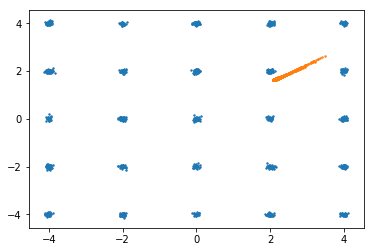

step 5000: discriminator: -1.724e+02, generator: 6.405e-42


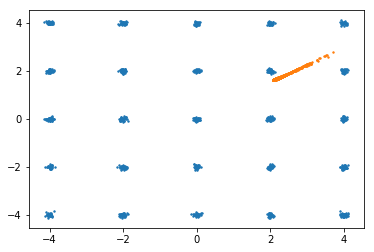

step 5100: discriminator: -1.546e+02, generator: 8.969e-36


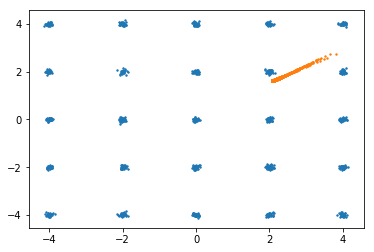

step 5200: discriminator: -1.601e+02, generator: 2.470e-21


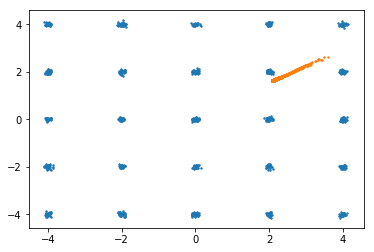

step 5300: discriminator: -1.648e+02, generator: 6.375e-28


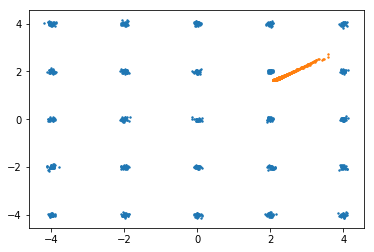

step 5400: discriminator: -1.587e+02, generator: 1.018e-37


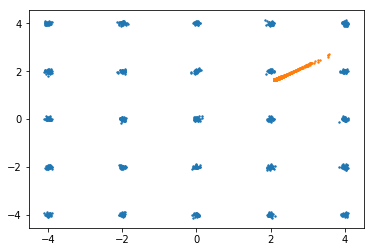

step 5500: discriminator: -1.629e+02, generator: 4.330e-43


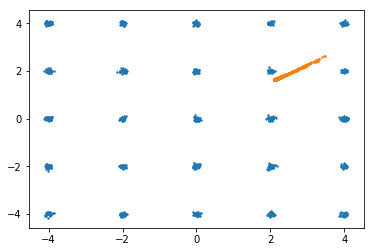

step 5600: discriminator: -1.714e+02, generator: 0.000e+00


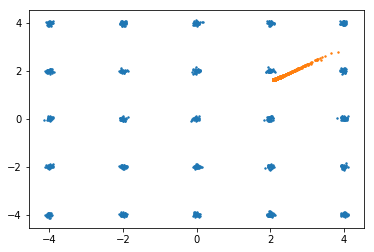

step 5700: discriminator: -1.763e+02, generator: 0.000e+00


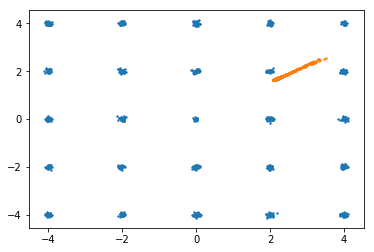

step 5800: discriminator: -1.705e+02, generator: 1.092e-33


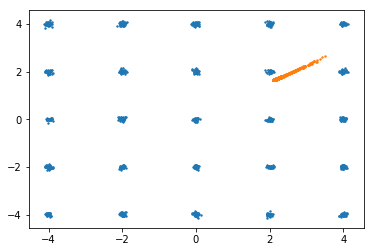

step 5900: discriminator: -1.634e+02, generator: 1.401e-44


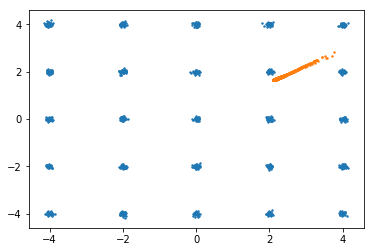

step 6000: discriminator: -1.558e+02, generator: 1.296e-20


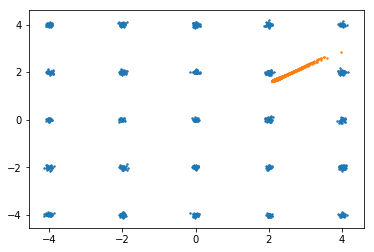

step 6100: discriminator: -1.721e+02, generator: 1.227e-39


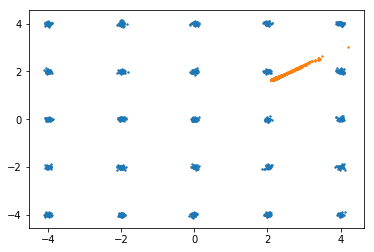

step 6200: discriminator: -1.598e+02, generator: 2.597e-35


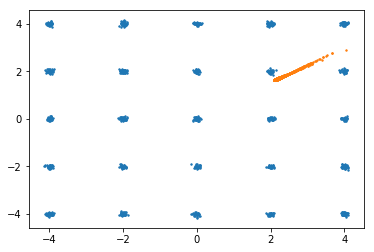

step 6300: discriminator: -1.753e+02, generator: 5.297e-43


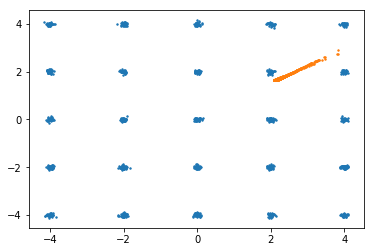

step 6400: discriminator: -1.687e+02, generator: 0.000e+00


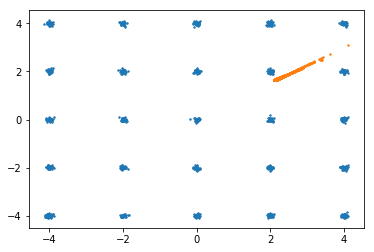

step 6500: discriminator: -1.801e+02, generator: 0.000e+00


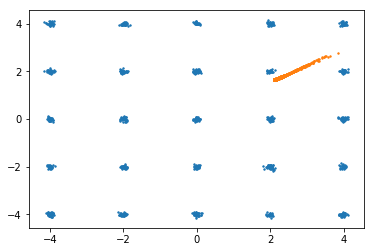

step 6600: discriminator: -1.658e+02, generator: 5.389e-41


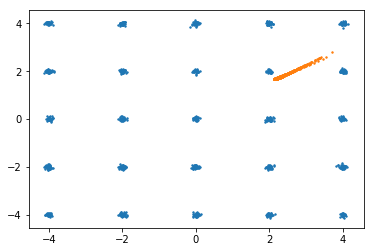

step 6700: discriminator: -1.816e+02, generator: 4.162e-43


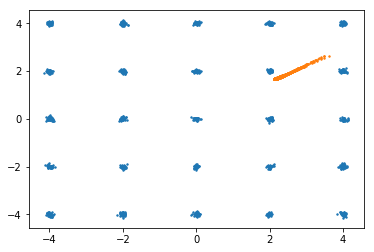

step 6800: discriminator: -1.490e+02, generator: 3.025e-26


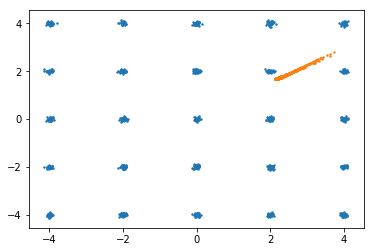

step 6900: discriminator: -1.578e+02, generator: 7.177e-35


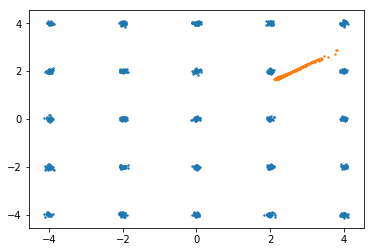

step 7000: discriminator: -1.605e+02, generator: 7.642e-33


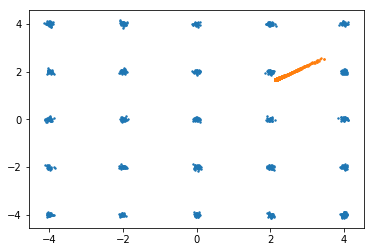

step 7100: discriminator: -1.648e+02, generator: 0.000e+00


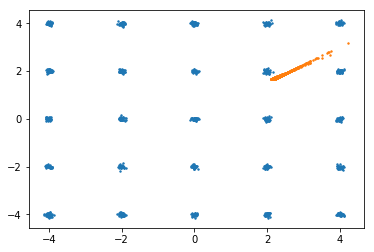

step 7200: discriminator: -1.574e+02, generator: 1.582e-29


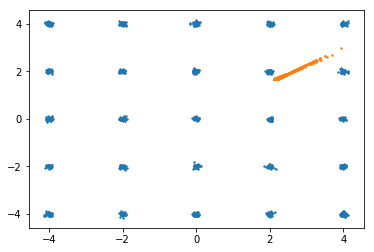

step 7300: discriminator: -1.672e+02, generator: 6.130e-40


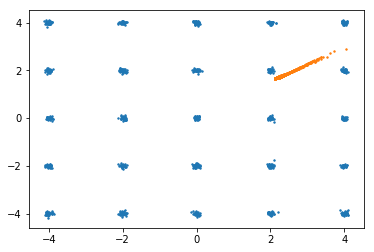

step 7400: discriminator: -1.621e+02, generator: 3.928e-29


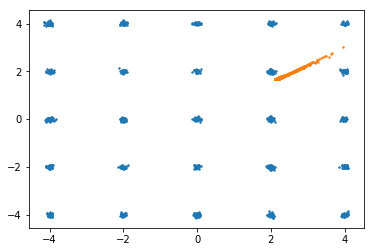

step 7500: discriminator: -1.805e+02, generator: 0.000e+00


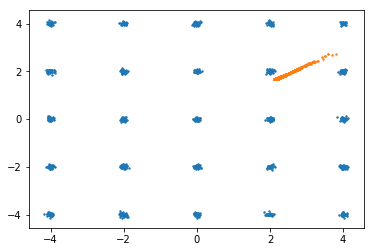

step 7600: discriminator: -1.598e+02, generator: 2.445e-30


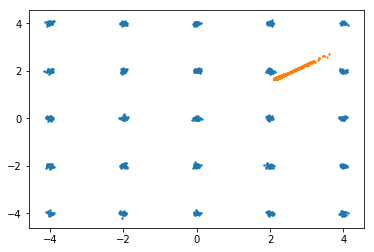

step 7700: discriminator: -1.659e+02, generator: 0.000e+00


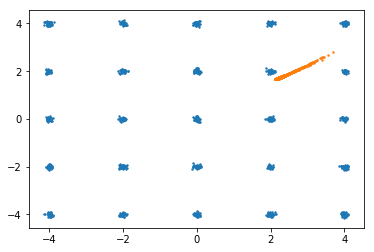

step 7800: discriminator: -1.858e+02, generator: 2.934e-42


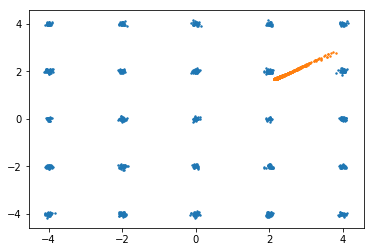

step 7900: discriminator: -1.799e+02, generator: 2.807e-41


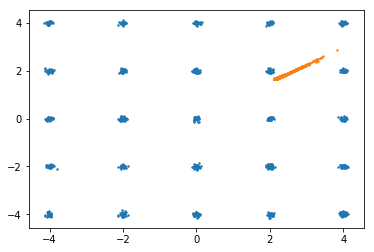

step 8000: discriminator: -1.646e+02, generator: 4.682e-41


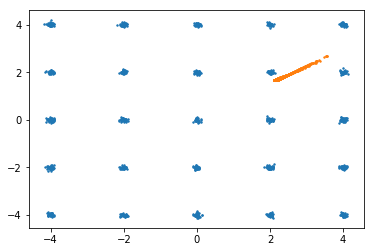

step 8100: discriminator: -1.712e+02, generator: 0.000e+00


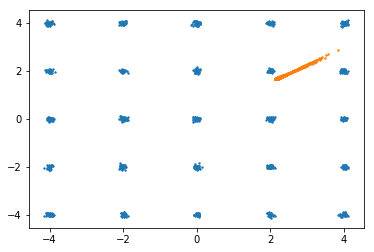

step 8200: discriminator: -1.833e+02, generator: 0.000e+00


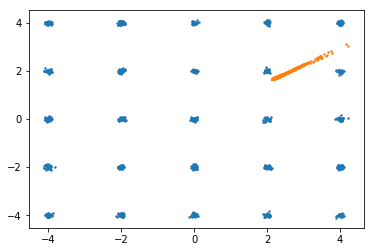

step 8300: discriminator: -1.699e+02, generator: 8.315e-42


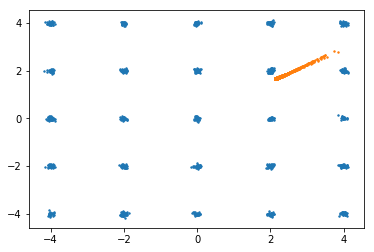

step 8400: discriminator: -1.621e+02, generator: 4.295e-41


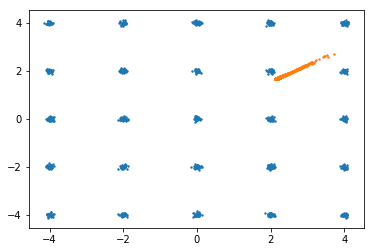

step 8500: discriminator: -1.465e+02, generator: 5.310e-26


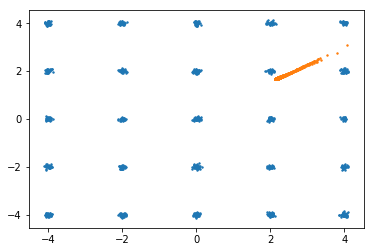

step 8600: discriminator: -1.651e+02, generator: 4.671e-42


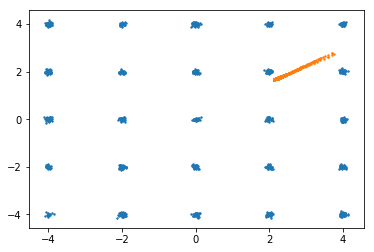

step 8700: discriminator: -1.573e+02, generator: 2.058e-28


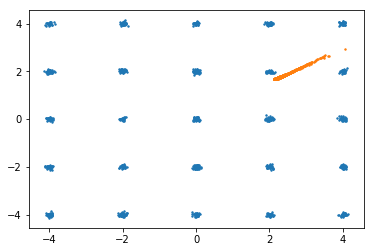

step 8800: discriminator: -1.490e+02, generator: 2.924e-38


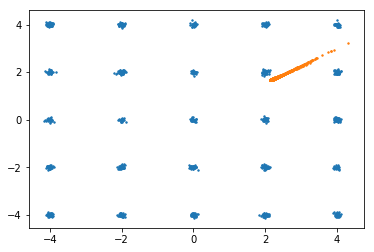

step 8900: discriminator: -1.703e+02, generator: 4.060e-42


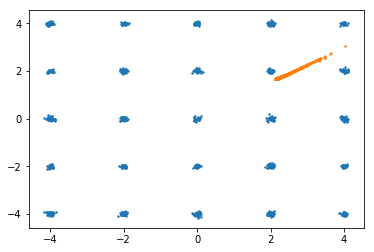

step 9000: discriminator: -1.684e+02, generator: 1.121e-38


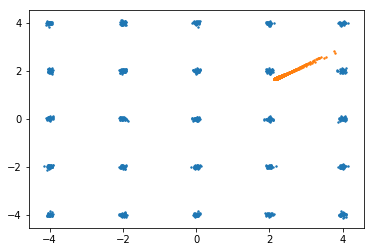

step 9100: discriminator: -1.483e+02, generator: 3.184e-31


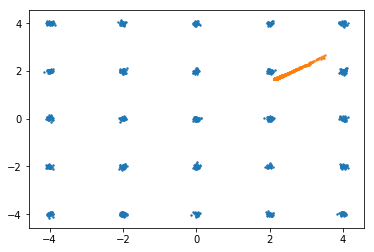

step 9200: discriminator: -1.622e+02, generator: 6.437e-40


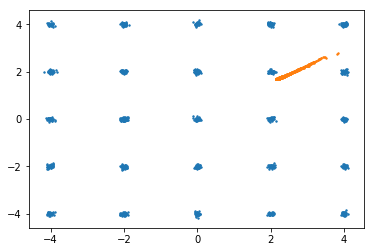

step 9300: discriminator: -1.691e+02, generator: 1.214e-38


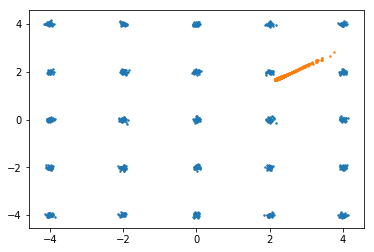

step 9400: discriminator: -1.626e+02, generator: 2.934e-34


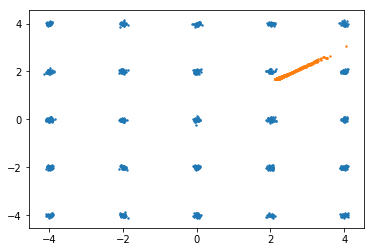

step 9500: discriminator: -1.769e+02, generator: 1.186e-30


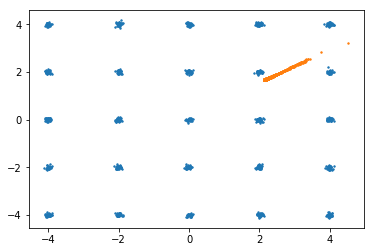

step 9600: discriminator: -1.656e+02, generator: 8.157e-42


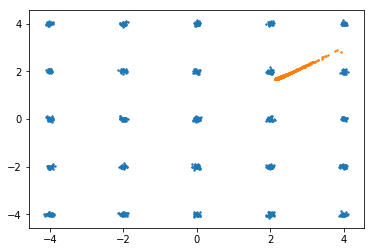

step 9700: discriminator: -1.645e+02, generator: 0.000e+00


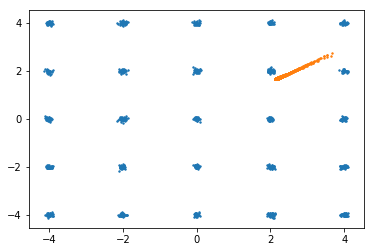

step 9800: discriminator: -1.685e+02, generator: 4.624e-44


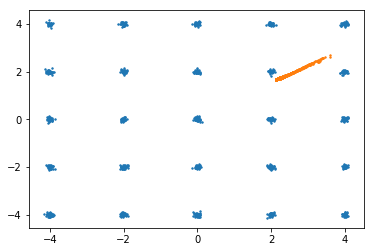

step 9900: discriminator: -1.659e+02, generator: 6.231e-26


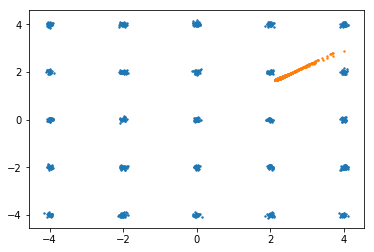

step 10000: discriminator: -1.700e+02, generator: 3.013e-43


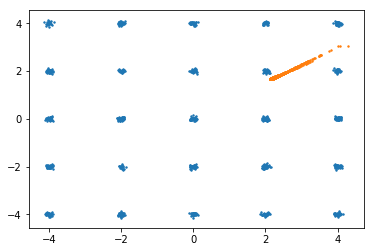

step 10100: discriminator: -1.544e+02, generator: 9.175e-28


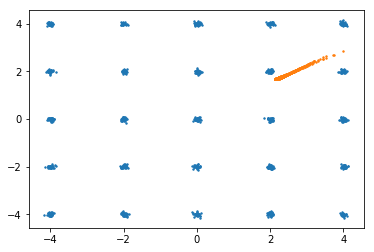

step 10200: discriminator: -1.733e+02, generator: 2.662e-44


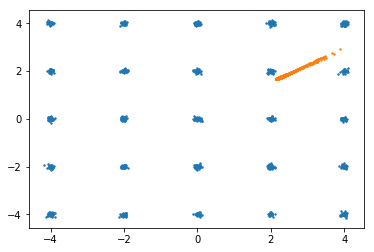

step 10300: discriminator: -1.783e+02, generator: 0.000e+00


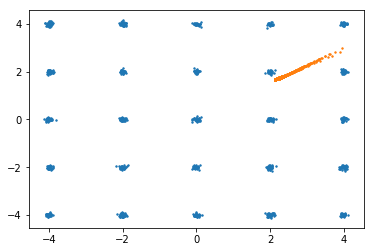

step 10400: discriminator: -1.730e+02, generator: 0.000e+00


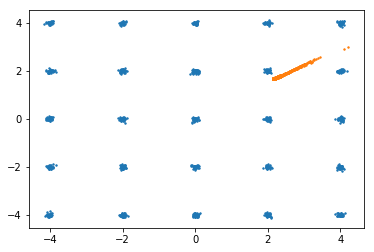

step 10500: discriminator: -1.700e+02, generator: 2.803e-45


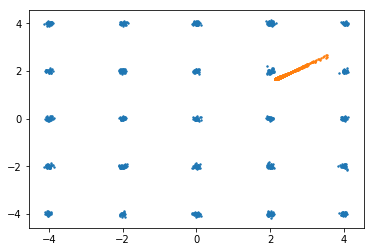

step 10600: discriminator: -1.748e+02, generator: 1.401e-45


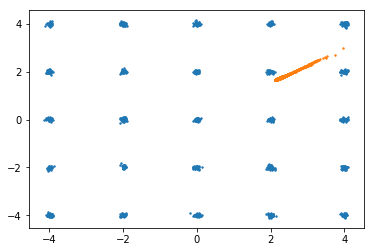

step 10700: discriminator: -1.685e+02, generator: 4.348e-40


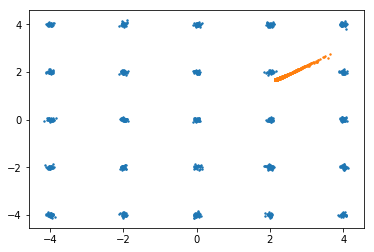

step 10800: discriminator: -1.683e+02, generator: 0.000e+00


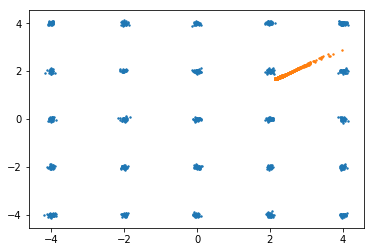

step 10900: discriminator: -1.686e+02, generator: 0.000e+00


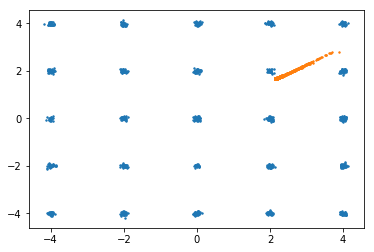

step 11000: discriminator: -1.667e+02, generator: 9.513e-32


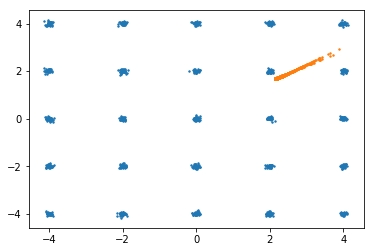

step 11100: discriminator: -1.575e+02, generator: 1.750e-33


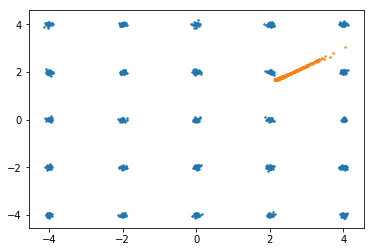

step 11200: discriminator: -1.499e+02, generator: 2.483e-30


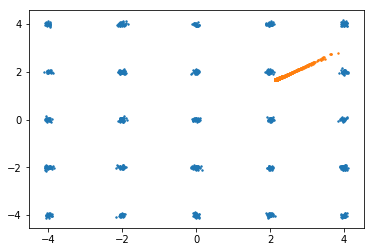

step 11300: discriminator: -1.588e+02, generator: 3.867e-36


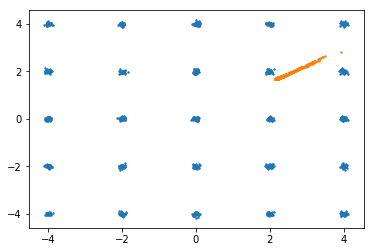

step 11400: discriminator: -1.664e+02, generator: 2.531e-42


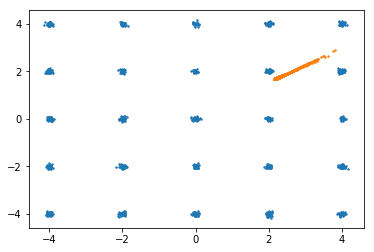

step 11500: discriminator: -1.740e+02, generator: 2.803e-44


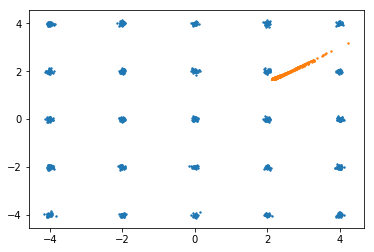

step 11600: discriminator: -1.792e+02, generator: 0.000e+00


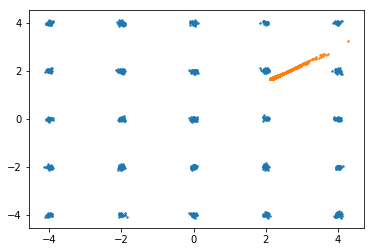

step 11700: discriminator: -1.653e+02, generator: 5.898e-40


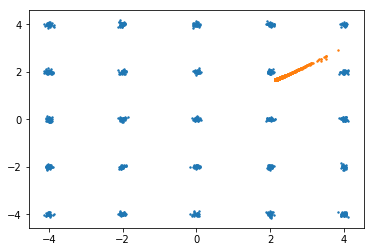

step 11800: discriminator: -1.818e+02, generator: 0.000e+00


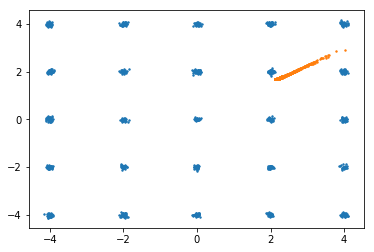

step 11900: discriminator: -1.696e+02, generator: 8.257e-29


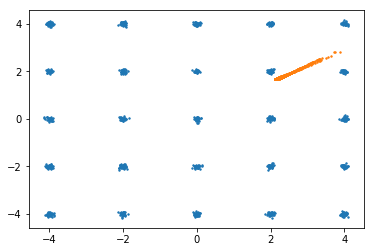

step 12000: discriminator: -1.639e+02, generator: 3.669e-42


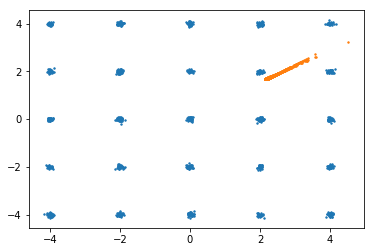

step 12100: discriminator: -1.863e+02, generator: 0.000e+00


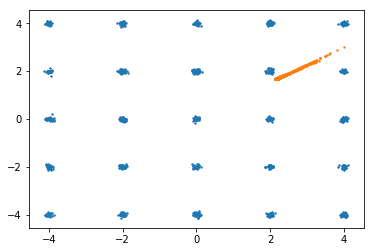

step 12200: discriminator: -1.875e+02, generator: 0.000e+00


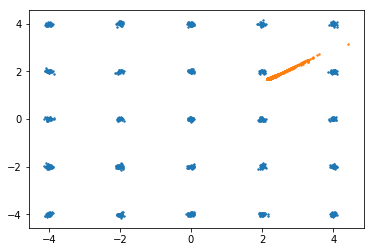

step 12300: discriminator: -1.701e+02, generator: 2.032e-43


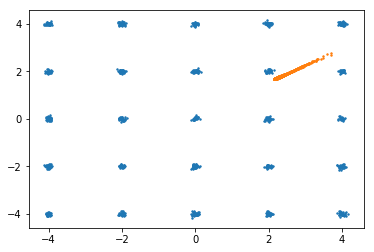

step 12400: discriminator: -1.701e+02, generator: 6.520e-39


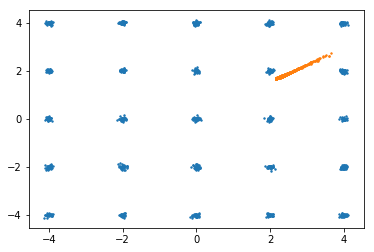

step 12500: discriminator: -1.681e+02, generator: 1.962e-44


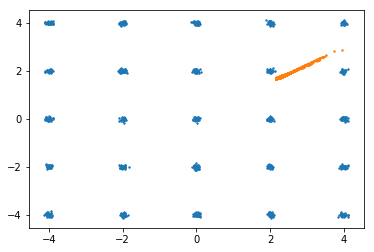

step 12600: discriminator: -1.837e+02, generator: 0.000e+00


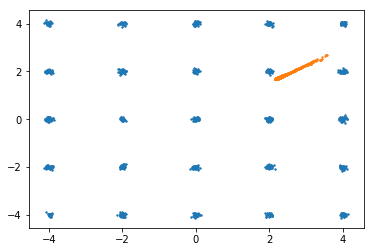

step 12700: discriminator: -1.677e+02, generator: 1.401e-45


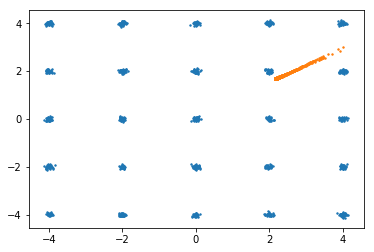

step 12800: discriminator: -1.892e+02, generator: 0.000e+00


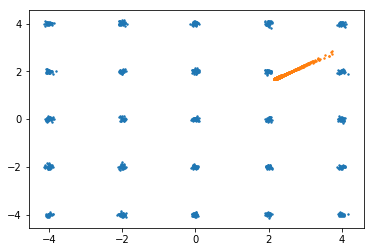

step 12900: discriminator: -1.713e+02, generator: 6.772e-32


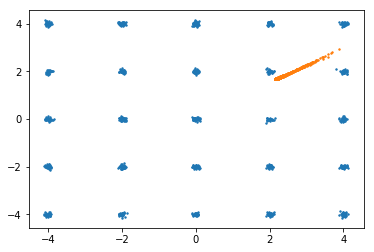

step 13000: discriminator: -1.752e+02, generator: 0.000e+00


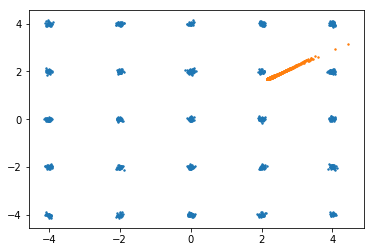

step 13100: discriminator: -1.746e+02, generator: 0.000e+00


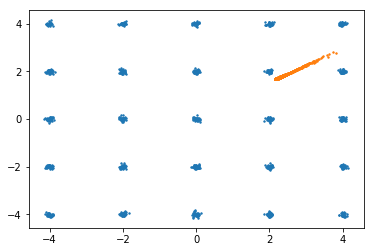

step 13200: discriminator: -1.729e+02, generator: 1.951e-40


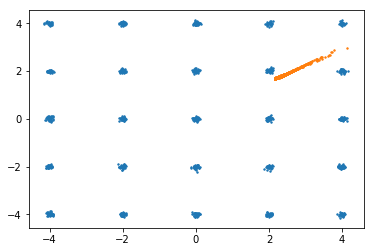

step 13300: discriminator: -1.651e+02, generator: 1.475e-19


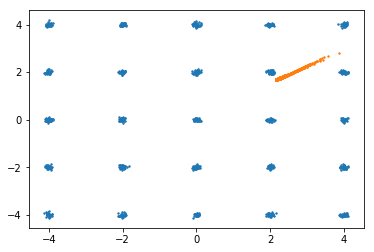

step 13400: discriminator: -1.732e+02, generator: 1.124e-42


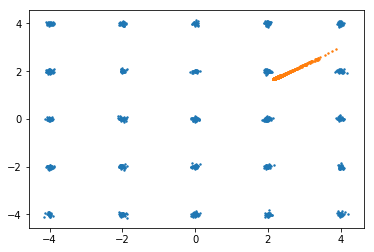

step 13500: discriminator: -1.700e+02, generator: 2.803e-44


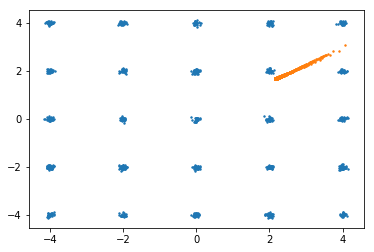

step 13600: discriminator: -1.725e+02, generator: 6.026e-44


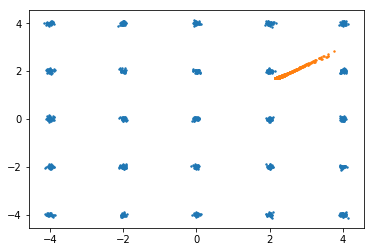

step 13700: discriminator: -1.767e+02, generator: 0.000e+00


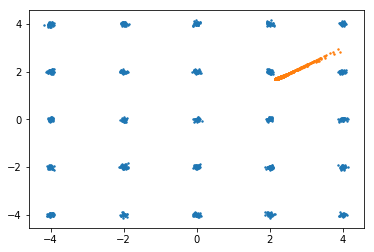

step 13800: discriminator: -1.908e+02, generator: 0.000e+00


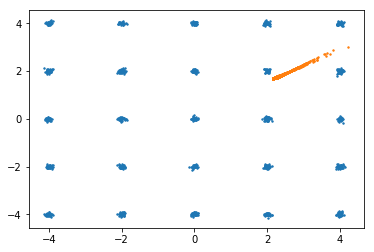

step 13900: discriminator: -1.713e+02, generator: 3.786e-38


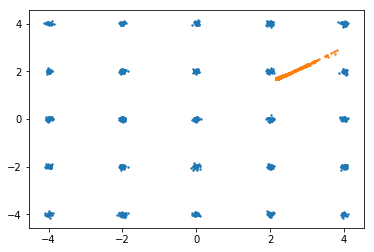

step 14000: discriminator: -1.644e+02, generator: 2.069e-36


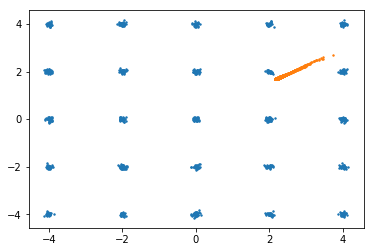

step 14100: discriminator: -1.679e+02, generator: 5.688e-40


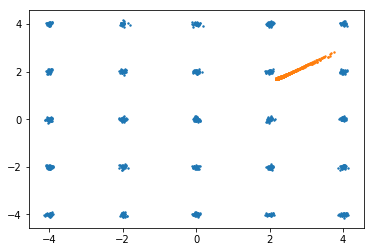

step 14200: discriminator: -1.771e+02, generator: 1.990e-43


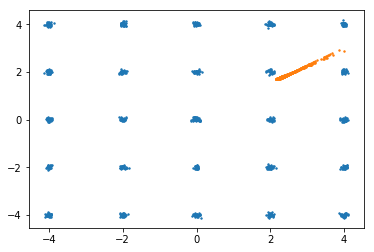

step 14300: discriminator: -1.460e+02, generator: 6.423e-20


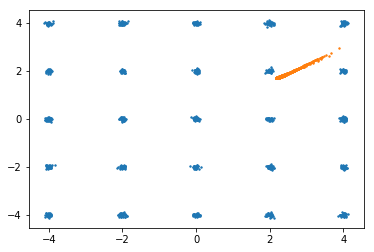

step 14400: discriminator: -1.641e+02, generator: 1.766e-43


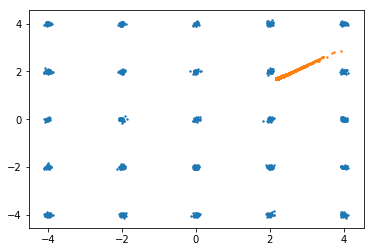

step 14500: discriminator: -1.769e+02, generator: 0.000e+00


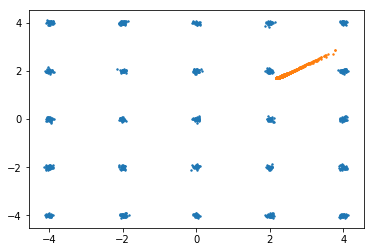

step 14600: discriminator: -1.872e+02, generator: 0.000e+00


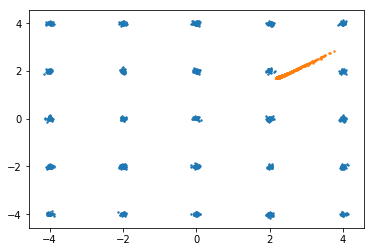

step 14700: discriminator: -1.715e+02, generator: 4.066e-33


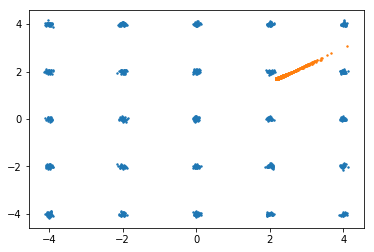

step 14800: discriminator: -1.628e+02, generator: 5.169e-30


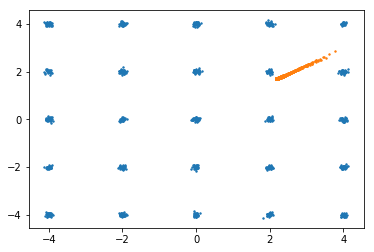

step 14900: discriminator: -1.803e+02, generator: 0.000e+00


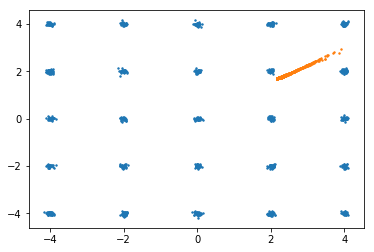

step 15000: discriminator: -1.744e+02, generator: 0.000e+00


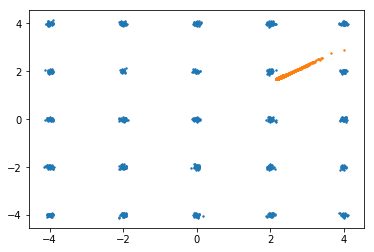

step 15100: discriminator: -1.819e+02, generator: 2.143e-40


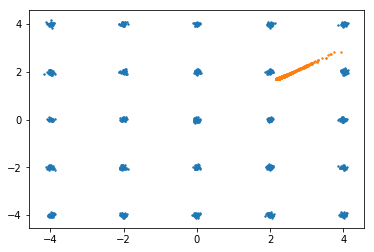

step 15200: discriminator: -1.639e+02, generator: 2.852e-33


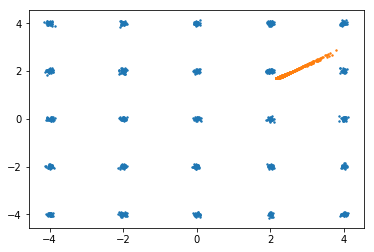

step 15300: discriminator: -1.795e+02, generator: 0.000e+00


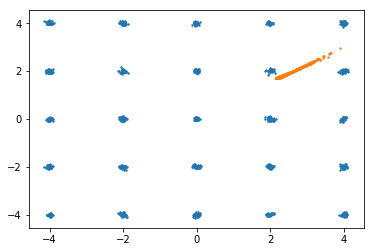

step 15400: discriminator: -1.730e+02, generator: 0.000e+00


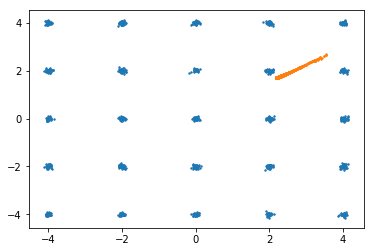

step 15500: discriminator: -1.731e+02, generator: 2.696e-39


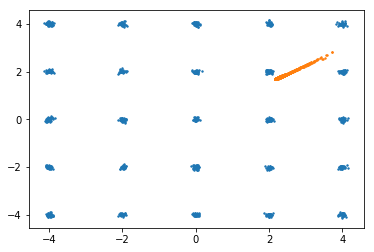

step 15600: discriminator: -1.687e+02, generator: 1.817e-42


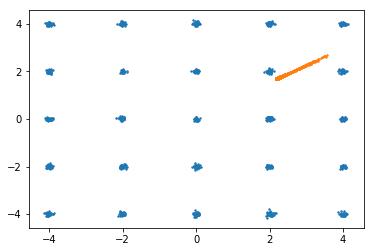

step 15700: discriminator: -1.787e+02, generator: 0.000e+00


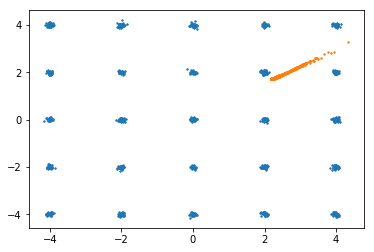

step 15800: discriminator: -1.884e+02, generator: 0.000e+00


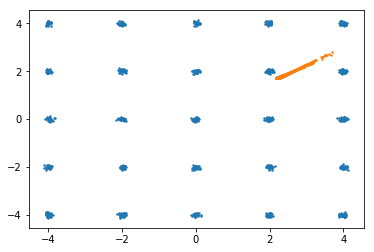

step 15900: discriminator: -1.624e+02, generator: 3.000e-22


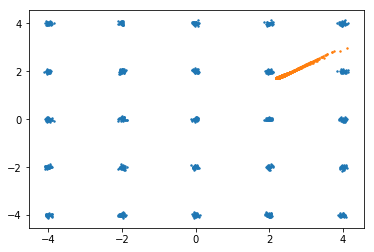

step 16000: discriminator: -1.648e+02, generator: 8.854e-37


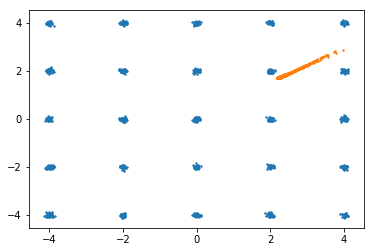

step 16100: discriminator: -1.653e+02, generator: 2.128e-38


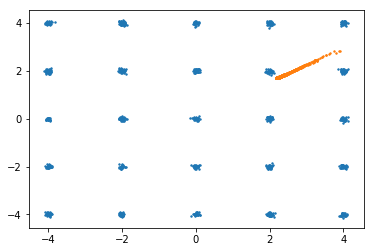

step 16200: discriminator: -1.550e+02, generator: 1.420e-31


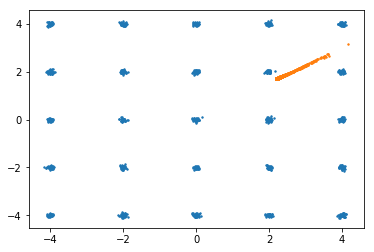

step 16300: discriminator: -1.736e+02, generator: 3.054e-39


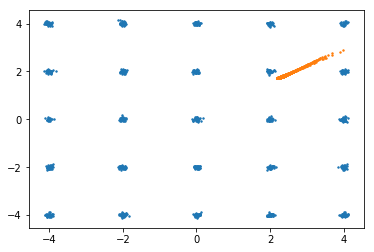

step 16400: discriminator: -1.775e+02, generator: 0.000e+00


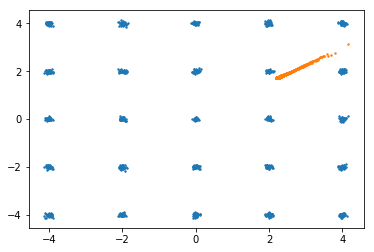

step 16500: discriminator: -1.627e+02, generator: 1.543e-28


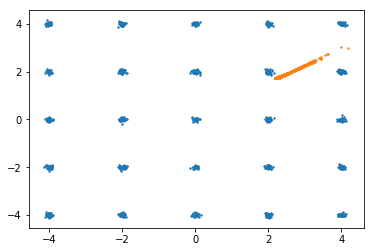

step 16600: discriminator: -1.769e+02, generator: 1.401e-45


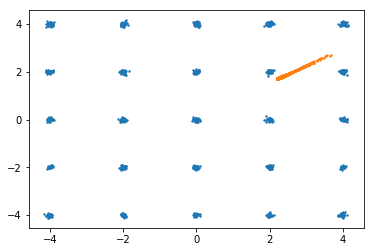

step 16700: discriminator: -1.896e+02, generator: 0.000e+00


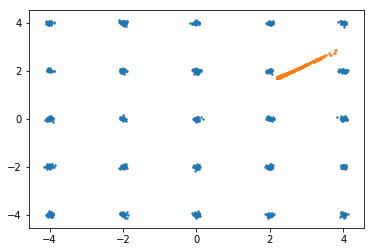

step 16800: discriminator: -1.597e+02, generator: 2.197e-36


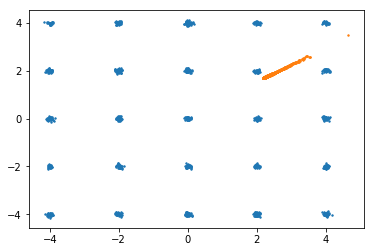

step 16900: discriminator: -1.794e+02, generator: 0.000e+00


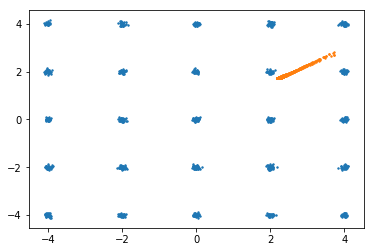

step 17000: discriminator: -1.640e+02, generator: 1.465e-29


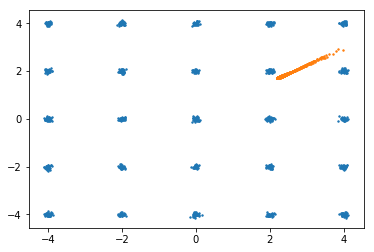

step 17100: discriminator: -1.755e+02, generator: 3.560e-37


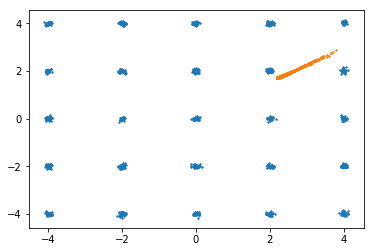

step 17200: discriminator: -1.623e+02, generator: 3.080e-32


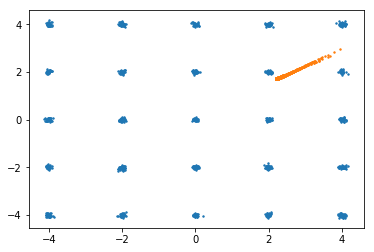

step 17300: discriminator: -1.841e+02, generator: 0.000e+00


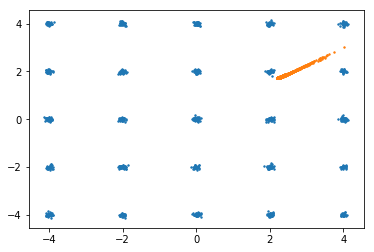

step 17400: discriminator: -1.598e+02, generator: 2.751e-26


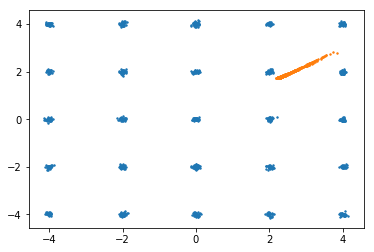

step 17500: discriminator: -1.720e+02, generator: 0.000e+00


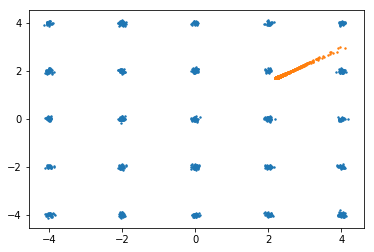

step 17600: discriminator: -1.707e+02, generator: 1.320e-29


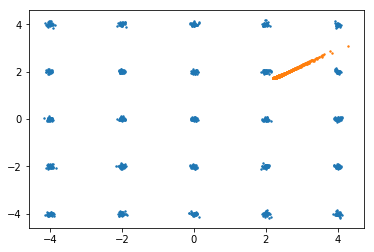

step 17700: discriminator: -1.581e+02, generator: 1.454e-26


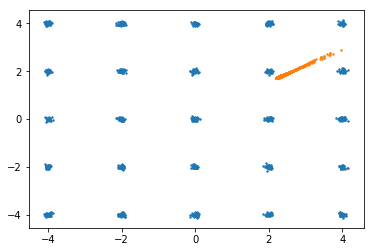

step 17800: discriminator: -1.873e+02, generator: 0.000e+00


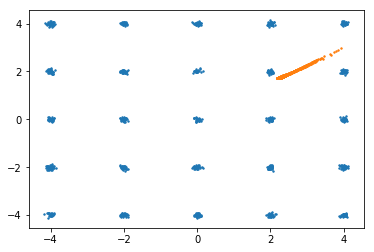

step 17900: discriminator: -1.718e+02, generator: 1.939e-39


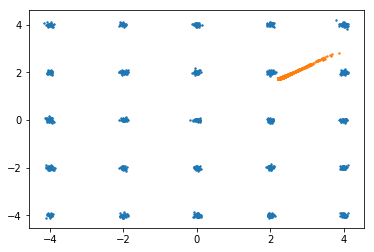

step 18000: discriminator: -1.684e+02, generator: 1.282e-34


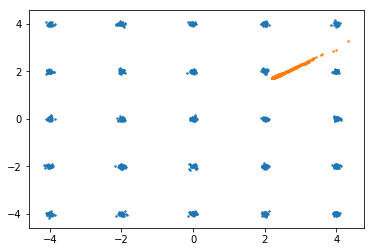

step 18100: discriminator: -1.746e+02, generator: 1.401e-45


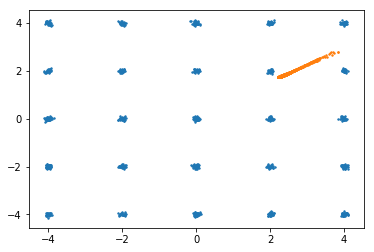

step 18200: discriminator: -1.736e+02, generator: 0.000e+00


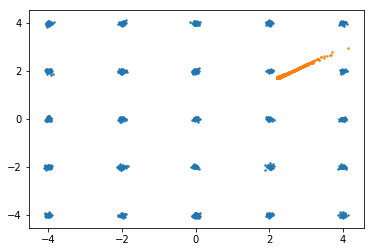

step 18300: discriminator: -1.748e+02, generator: 0.000e+00


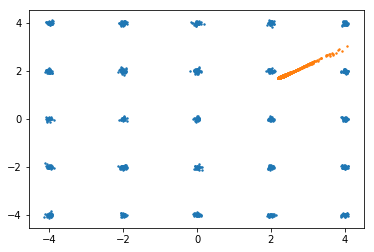

step 18400: discriminator: -1.791e+02, generator: 0.000e+00


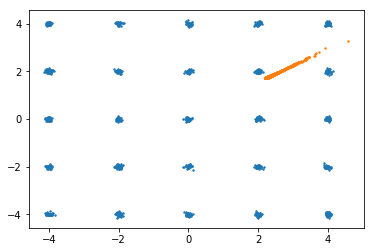

step 18500: discriminator: -1.719e+02, generator: 4.850e-38


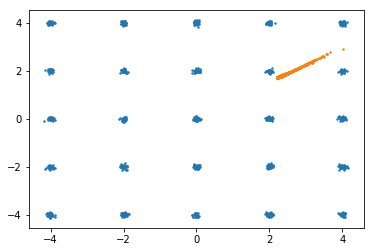

step 18600: discriminator: -1.724e+02, generator: 7.594e-39


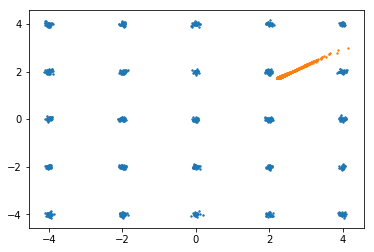

step 18700: discriminator: -1.746e+02, generator: 0.000e+00


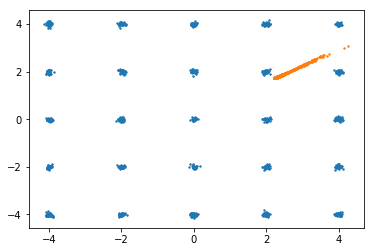

step 18800: discriminator: -1.685e+02, generator: 3.764e-40


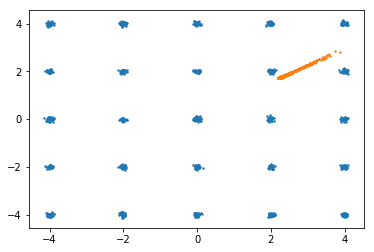

step 18900: discriminator: -1.716e+02, generator: 4.779e-40


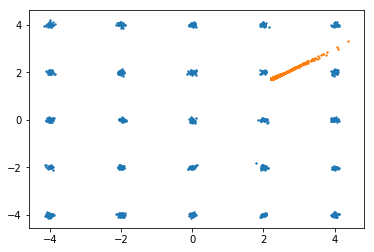

step 19000: discriminator: -1.621e+02, generator: 1.298e-41


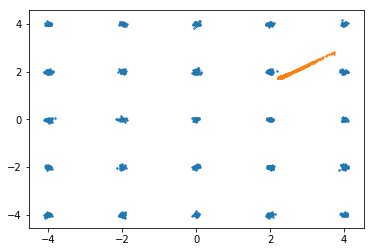

step 19100: discriminator: -1.676e+02, generator: 1.588e-39


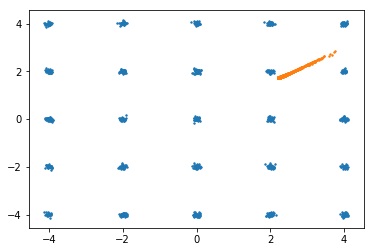

step 19200: discriminator: -1.731e+02, generator: 4.979e-38


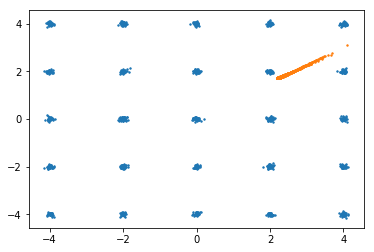

step 19300: discriminator: -1.721e+02, generator: 7.280e-31


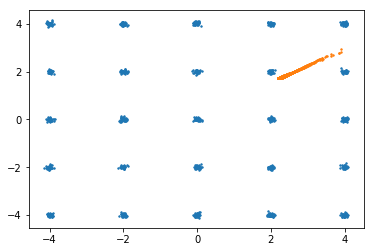

step 19400: discriminator: -1.782e+02, generator: 4.274e-43


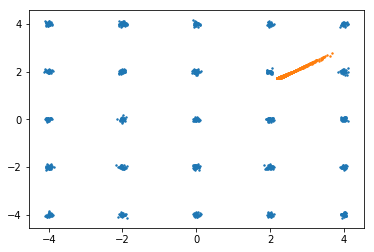

step 19500: discriminator: -1.709e+02, generator: 1.401e-45


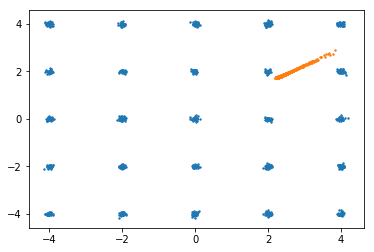

step 19600: discriminator: -1.914e+02, generator: 0.000e+00


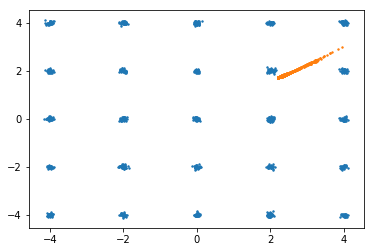

step 19700: discriminator: -1.705e+02, generator: 3.404e-38


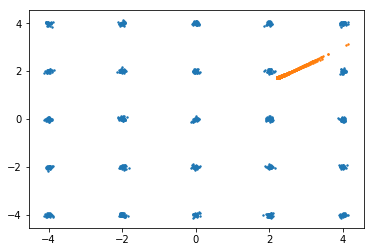

step 19800: discriminator: -1.518e+02, generator: 1.740e-27


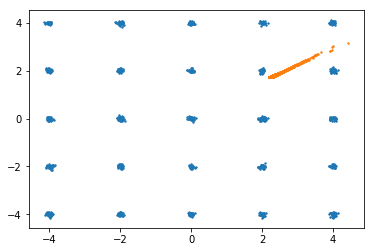

step 19900: discriminator: -1.712e+02, generator: 2.803e-44


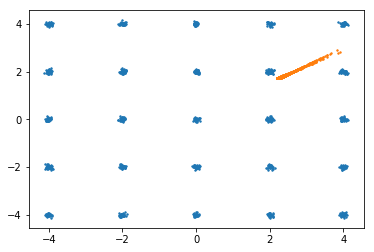

step 20000: discriminator: -1.675e+02, generator: 1.656e-42


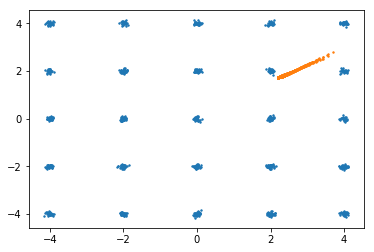

In [67]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 10
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
        # torch.softplus, using real_batch and fake_batch
        # FILL HERE
        disc_loss = 2*(torch.log(torch.Tensor([2]))-JSD(F.softplus(real_batch),F.softplus(fake_batch)))
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    # Compute here the generator loss, using fake_batch
    #gen_loss = torch.sum(torch.log(1-F.softplus(fake_batch))) #First loss
    gen_loss = F.softplus(torch.sum(-torch.log(F.softplus(fake_batch-real_batch)))) #Second loss
    gen_loss.backward()
    optim_gen.step()
    if i%100 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> The generator collapses because it generates fake data. If the false data have too large values, the softplus function takes a value greater than 1 and we have a negative value in the logarithm that returns a nan value that makes the generator collapse.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> (write your answer here)

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

An other well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

> $min_{p}(D_{KL}(p_{D}||p_{\Theta }))= min_{p}(E_{p_{D}}\left [ ln(\frac{p_{D}(x)}{p(x)}) \right ]) =max_{p}(E_{p_{D}}log_{p_{\Theta }}(x))$

However, the class of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution like so: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Where here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)ds$ is an infinite mixture of gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce an other, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} - \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> A part of data won't be train? Pas sur du tout de ce qu'il a dit

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> (write your answer here)

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z)))$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> (write your answer here)

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian q_\phi(z | x)
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 2)
        self.fc_mu = nn.Linear(2, 2)
        self.fc_logvar = nn.Linear(2, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the gaussian p_\theta(z | x)
    def __call__(self, z):
        h = F.elu(self.fc1(z))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution in a differentiable way using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

> (write your answer here)

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    # Compute here the DKL part of the VAE loss
    loss_kl = 0 # FILL HERE
    # Compute here the sample z, using Q12
    z = 0 # FILL HERE
    
    dec_mu, dec_logvar = decoder(z)
    # Compute here the second part of the VAE loss
    loss_rec = 0 # FILL HERE
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%100 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

> (write your answer here)

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

> (write your answer here)

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

> (write your answer here)